In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

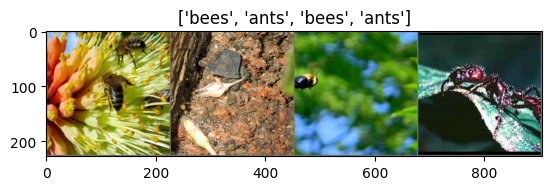

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Load the pre-trained ResNet-18 model without the final classification layer
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Replace the final classification layer for your specific task
model_ft.fc = nn.Linear(num_ftrs, 2)  

# Move the model to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [20]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6657 Acc: 0.6352
val Loss: 0.2943 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.4738 Acc: 0.7828
val Loss: 0.3132 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4848 Acc: 0.8156
val Loss: 0.1719 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4543 Acc: 0.7910
val Loss: 0.2953 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3415 Acc: 0.8648
val Loss: 0.2015 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5228 Acc: 0.8074
val Loss: 0.2530 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3138 Acc: 0.8811
val Loss: 0.4768 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.3316 Acc: 0.8689
val Loss: 0.2499 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3677 Acc: 0.8443
val Loss: 0.2804 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3421 Acc: 0.8689
val Loss: 0.2382 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3463 Acc: 0.8525
val Loss: 0.2560 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.4183 Acc: 0.8197
val Loss: 0.2077 Acc: 0.9281

Ep

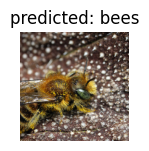

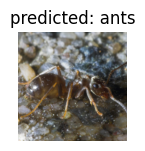

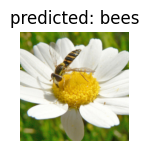

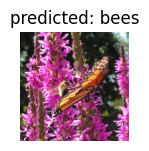

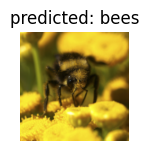

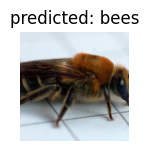

In [10]:
visualize_model(model_ft)

In [12]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Load the pre-trained ResNet-18 model without the final classification layer
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  

# Move the model to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, only for the parameters of the final layer (fc)
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6404 Acc: 0.6393
val Loss: 0.2149 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.4994 Acc: 0.7746
val Loss: 0.1786 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4792 Acc: 0.8033
val Loss: 0.1963 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4329 Acc: 0.8238
val Loss: 0.1921 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3839 Acc: 0.8238
val Loss: 0.4401 Acc: 0.7974

Epoch 5/24
----------
train Loss: 0.5704 Acc: 0.7705
val Loss: 0.1805 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3181 Acc: 0.8443
val Loss: 0.1630 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4303 Acc: 0.8361
val Loss: 0.1715 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2978 Acc: 0.8893
val Loss: 0.1830 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3289 Acc: 0.8197
val Loss: 0.1799 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2636 Acc: 0.8811
val Loss: 0.1829 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4481 Acc: 0.8279
val Loss: 0.2016 Acc: 0.9412

Ep

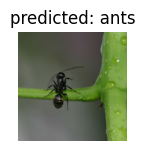

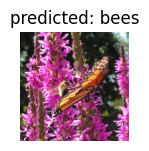

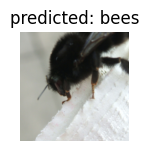

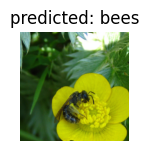

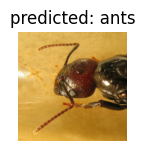

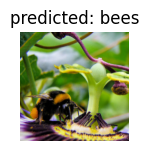

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

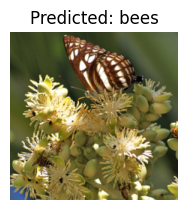

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()